# Deadheading in Ride-Hailing

**Authors:** Juan Carrillo, Anas Mahmoud and Sheran Cardoza<br>
**Course:** ECE1724H: Bio-inspired Algorithms for Smart Mobility - Fall 2021<br>
**Instructor:** Dr. Alaa Khamis<br>
**Department:** Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto





## Introduction

Ridesharing is one of several on-demand mobility services gaining momentum in recent years
and represents a flexible and convenient alternative for transportation. Despite its
attractiveness, ridesharing also causes undesired effects such as increased traffic and
emissions. In this project, we study specifically the problem of ridesharing vehicles roaming
without passengers, also known as deadheading.

In [31]:
import copy
import time
import random
import statistics
from math import cos
from configparser import ConfigParser

# Data and plotting
import numpy as np
import pandas as pd
from pandas.io import parsers
import folium
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mobility
import osmnx
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.common import cost
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.search import dijkstra, astar

# Data

The data source for this example contains 175 delivery records for addresses in the Greater Toronto Area (GTA).

These entries with latitude and longitude information are then converted into OSM Node IDs (closest node). One location is assigned per vehicle as a "initial depot location". Each rider is assigned a pickup node and a dropoff node.

## Problem Classes

### Rider

In [32]:
class Rider(object):
    def __init__(
    self,
    id: int,
    pickup_location: tuple,
    dropoff_location: tuple,
    pickup_map_node_id: int,
    dropoff_map_node_id: int
    ):
        """ Instantiate a rider object
        Parameters
        ----------
        id : A unique id for each rider
        pickup_location: pickup lat and long
        dropoff_location: dropoff lat and long
        pickup_map_node_id: osmid of the nearest node to pickup_location
        dropoff_map_node_id: osmid of the nearest node to dropoff_location
        """
        self.id = id
        self.pickup_location = pickup_location
        self.dropoff_location = dropoff_location
        self.pickup_map_node_id = pickup_map_node_id
        self.dropoff_map_node_id = dropoff_map_node_id
    def __str__(self)->str:
        return "ID of rider: {}\n".format(self.id) + \
               "Pickup location of rider: {} {}\n".format(self.pickup_location[0], self.pickup_location[1]) + \
               "Dropoff location of rider: {} {}\n".format(self.dropoff_location[0], self.dropoff_location[1]) + \
               "Pickup node id of rider: {}\n".format(self.pickup_map_node_id) + \
               "Dropoff node id of rider: {}\n".format(self.dropoff_map_node_id)

### Driver

In [33]:
class Driver(object):
    def __init__(
    self,
    id,
    initial_location: tuple,
    initial_map_node_id: int
    ):
        """Instantiate a drive object
        Parameters
        ----------
        id : A unique id for each driver
        initial_location: initial lat and long
        initial_map_node_id: osmid of the nearest node to initial driver location
        """
        self.id = id
        self.initial_location = initial_location
        self.initial_map_node_id = initial_map_node_id
    def __str__(self) -> str:
        return "ID of driver: {}\n".format(self.id) + \
               "Initial location of driver: {} {}\n".format(self.initial_location[0], self.initial_location[1]) + \
               "Initial node id of driver: {}\n".format(self.initial_map_node_id)

### Coord (Node)

In [34]:
class Coord(object):
    def __init__(self, lat, lng, osmid):
        self.lat   = lat
        self.lng   = lng
        self.osmid = osmid
    
    def __repr__(self):
        return "[lat,lng,id]=[{},{},{}]".format(self.lat, self.lng, self.osmid)
    
    def __eq__(self, other):
        if isinstance(other, Coord):
            return self.osmid == other.osmid
        return False
    
    def __ne__(self, other):
        return not self == other

### Data Sampler

This class processes raw data and converts into a usable format.

In [35]:
class Sampler(object):
    def __init__(self):
        pass

    def prepare_data(self, df):
        """Convert raw data to custom data format
        Parameters
        ----------
        df : dataframe object of raw data
        Returns
        ----------
        dataframe object of custom data
        """

        df = df.drop_duplicates()

        # Pick midpoint of all coordinates as the center of the graph
        self.midpoint = (df['dropoff_lat'].mean(), df['dropoff_lng'].mean())

        # Calculate radius as distance of farthest coordinate from midpoint
        dists = [osmnx.distance.great_circle_vec(self.midpoint[0], self.midpoint[1], row['dropoff_lat'], row['dropoff_lng']) for _, row in df.iterrows()]
        self.radius = max(dists)
        # self.radius = 2000

        # Generate graph (takes a long time)
        graph = osmnx.graph.graph_from_point(
            self.midpoint, dist=self.radius, clean_periphery=True, simplify=True)

        # Project graph
        #graph = osmnx.project_graph(graph, to_crs={'init': 'epsg:32617'})

        # Extract coord info
        lats   = []
        lngs   = []
        osmids = []
        for index, row in df.iterrows():
            lat   = row['dropoff_lat']
            lng   = row['dropoff_lng']
            osmid = osmnx.distance.nearest_nodes(graph, lng, lat)
            lats.append(lat)
            lngs.append(lat)
            osmids.append(osmid)

        # Create dataframe
        new_df = pd.DataFrame(list(zip(lats, lngs, osmids)),
                              columns=['lat','lng','osmid'])

    def init_data(self, df):
        """Initialize Sampler class attributes with prepared data
        Parameters
        ----------
        df : dataframe object of prepared data
        """

        df = df.drop_duplicates()

        # Pick midpoint of all coordinates as the center of the graph
        self.midpoint = (df['lat'].mean(), df['lng'].mean())

        # Calculate radius as distance of farthest coordinate from midpoint
        dists = [osmnx.distance.great_circle_vec(self.midpoint[0], self.midpoint[1], row['lat'], row['lng']) for _, row in df.iterrows()]
        self.radius = max(dists)

        # Extract coords
        self.coords = [Coord(row['lat'], row['lng'], row['osmid']) for _,row in df.iterrows()]

        # Debug info
        print("Num coords = {}".format(len(self.coords)))
        seen = set()
        unique_ids = [seen.add(coord.osmid) or coord for coord in self.coords if coord.osmid not in seen]
        print("Num coords with unique node id = {}".format(len(unique_ids)))

    def get_samples(self, n_drivers, n_riders, radius=None, midpoint=None, return_graph=True):
        """Return sample data containing drivers, riders, and graph
        Parameters
        ----------
        n_drivers   : number of drivers
        n_riders    : number of riders
        radius      : radius in metres
        midpoint    : midpoint as a tuple of (lat, lng)
        return_graph: generate a graph based on midpoint and radius
        Returns
        ---------
        drivers     : list of Driver objects
        riders      : list of Rider objects
        graph       : (optional) if return_graph=True, returns graph of nodes
        """
        assert n_drivers < n_riders
        midpoint = self.midpoint if midpoint is None else midpoint
        radius = self.radius if radius is None else radius

        # Find valid coords within this radius
        coords = []
        for coord in self.coords:
            dist = osmnx.distance.great_circle_vec(midpoint[0], midpoint[1], coord.lat, coord.lng)
            if dist <= radius:
                coords.append(coord)

        assert n_drivers + n_riders * \
            2 <= len(coords), "Error: n_drivers={} + n_riders*2={} > available_coords={}".format(
                n_drivers, n_riders*2, len(coords))

        # Shuffle the coords for some randomization
        # commented for debugging purposes
        random.shuffle(coords)

        # Assign drivers
        drivers = []
        for i, coord in enumerate(coords):
            if i < n_drivers:
                drivers.append(Driver(i, (coord.lat, coord.lng), coord.osmid))
            else:
                # Delete the drivers
                coords = coords[i+1:]
                break

        # Delete any excess coords we don't need
        coords = coords[0:2*n_riders]

        # Assign riders
        riders = []
        it = iter(coords)
        for i, coord in enumerate(it):
            pickup = coord
            dropoff = next(it)
            riders.append(Rider(i, (pickup.lat, pickup.lng),
                          (dropoff.lat, dropoff.lng), pickup.osmid, dropoff.osmid))

        if return_graph:
            # Generate graph for this custom radius
            graph = osmnx.graph.graph_from_point(
                midpoint, dist=radius, clean_periphery=True, simplify=True)
            return drivers, riders, graph

        return drivers, riders

In [36]:
sampler = Sampler()

# Data preparation takes a long time.
# Run just once and save to a CSV, then in subsequent runs
# just use the saved CSV.

# Load in the data
start = time.time()
filename = 'PreparedData.csv'
df = pd.read_csv(filename)
sampler.init_data(df)
end = time.time()
print("Data init time = {} seconds".format(end - start))

Num coords = 169
Num coords with unique node id = 168
Data init time = 0.023195981979370117 seconds


In [37]:
start = time.time()
radius = 6000
num_drivers = 3
num_riders = 7
dt_midpoint = (43.653225, -79.383186)
drivers, riders, graph = sampler.get_samples(
    num_drivers, num_riders, radius=radius, midpoint=dt_midpoint, return_graph=True)
end = time.time()
print("Samples time = {} seconds".format(end - start))

print("Samples contains the following:")
print(f'{len(drivers)} drivers')
print(f'{len(riders)} riders')
print(f'{len(graph.nodes())} graph nodes')

Samples time = 26.448352813720703 seconds
Samples contains the following:
3 drivers
7 riders
48268 graph nodes


### Plot
Used to visualize coordinates on a map.

In [38]:
class Plot():
    def __init__(self, drivers, riders, graph) -> None:
        """Initializes a plot object
        Args:
            drivers (list): drivers available
            riders (list): riders requesting service
            graph (networkx.classes.multidigraph.MultiDiGraph): road network
        """
        self.drivers = drivers
        self.riders = riders
        self.graph = graph
        self.map = None

    def calc_centroid(self):
        """ calculates centroid of points to plot
        Returns:
            list: latitude and longitude values of the centroid
        """
        avg_lat = 0
        avg_lon = 0
        total_coords = len(self.drivers) + 2*len(self.riders)

        for driver in self.drivers:
            driver_ini_lat, driver_ini_lon = driver.initial_location
            avg_lat += driver_ini_lat
            avg_lon += driver_ini_lon

        for rider in self.riders:
            rider_pic_lat, rider_pic_lon = rider.pickup_location
            rider_dro_lat, rider_dro_lon = rider.dropoff_location
            avg_lat += rider_pic_lat + rider_dro_lat
            avg_lon += rider_pic_lon + rider_dro_lon

        avg_lat /= total_coords
        avg_lon /= total_coords

        return [avg_lat, avg_lon]

    def init_basemap(self):
        """ initializes a folium basemap centered over drivers and riders
        """
        self.map = folium.Map(location=self.calc_centroid(), zoom_start=10)

    def add_pins_to_basemap(self):
        """ adds locations to basemap
        """
        # checks that a basemap is initialized
        assert (self.map is not None), "must initialize basemap before adding locations"
        for driver in self.drivers:
            folium.Marker(location=list(driver.initial_location),
                          popup=f'driver {driver.id}',
                          icon=folium.map.Icon(color='orange')
                          ).add_to(self.map)
        for rider in self.riders:
            folium.Marker(location=list(rider.pickup_location),
                          popup=f'rider {rider.id}: pickup',
                          icon=folium.map.Icon(color='blue')
                          ).add_to(self.map)
            folium.Marker(location=list(rider.dropoff_location),
                          popup=f'rider {rider.id}: dropoff',
                          icon=folium.map.Icon(color='red')
                          ).add_to(self.map)

    def basemap_to_html(self):
        """ exports the basemap with pins to html
        """
        # checks that a basemap is initialized
        assert (self.map is not None), "must initialize basemap before saving"
        self.map.save('basemap_with_pins.html')

    def plot_graph_with_nodes(self):
        """ plots the graph with nodes classified in colors
        Args:
            graph
        """

        colors_dict = self.get_colors_dict()
        all_nodes_colors = self.get_nodes_colors(colors_dict)

        all_nodes_size = [50 if node_id in colors_dict.keys() else 2
                          for node_id in self.graph.nodes]

        fig, ax = osmnx.plot_graph(
            self.graph, node_size=all_nodes_size,
            node_color=all_nodes_colors, node_zorder=2,
            bgcolor='#F2F3F5', edge_color='#B3B5B7',
            save=True, filepath='graph_and_nodes.png')

    def get_colors_dict(self):
        """ generates a dictionary mapping node ids to colors
        Returns:
            colors_dict
        """
        c_orange = '#FF8A33'  # drivers
        c_blue = '#3AACE5'  # rider pickup
        c_red = '#FF3352'  # rider drop off

        colors_dict = {}

        for driver in self.drivers:
            colors_dict[driver.initial_map_node_id] = c_orange

        for rider in self.riders:
            colors_dict[rider.pickup_map_node_id] = c_blue
            colors_dict[rider.dropoff_map_node_id] = c_red

        return colors_dict

    def get_nodes_colors(self, colors_dict):
        """ generates a list with color for each node id in graph
        Args:
            colors_dict
        Returns:
            all_nodes_colors
        """
        c_grey = '#B3B5B7'
        all_nodes_colors = []
        for node_id in self.graph.nodes:
            try:
                all_nodes_colors.append(colors_dict[node_id])
            except:
                all_nodes_colors.append(c_grey)
        return all_nodes_colors

## Problem Formulation


## Formulation

The evaluation function is a multi-objective cost function and includes:
1. Minimizing deadheading by searching for solutions that reduce miles driven without passengers, 
2. Maximizing fairness between independent drivers by encouraging solutions that minimize the standard deviation of the ratio between miles driven with a passenger over miles driven without a passenger
3. Maximizing fairness between wait-time of customers by minimizing the standard deviation of customer's wait time
4. Maximizing profit by serving higher priority customers before lower priority customers. 

The following is the multi-objective function that we wish to minimize:

\begin{align*}
    f =& \underbrace{\alpha_{dh}\sum_{j=1}^{|D|} \left(\sum_{i=1}^{|d_{j}|-1} dis(c_{i, dr}, c_{i+1, cl})) \right) + dis(d_{j,0}, c_{1, cl})}_{\text{Deadheading cost}}+ \\
       & \underbrace{\alpha_{d}\sqrt{\frac{\sum_{j=1}^{|D|} \left(\frac{Pr_j}{Dh_j} - \mu_{pd}\right)^2}{|D|}}}_{\text{Driver fairness}} +  \underbrace{\alpha_c\sqrt{\frac{ \sum_{i=1}^{|C|} \left(ds_i - \mu_{ds}\right)^2}{|C|}}}_{\text{Customer fairness}} -  \\
       &\underbrace{\alpha_p\sum_{j=1}^{|D|} \sum_{i=1}^{|d_{j}|} \frac{dis(c_{i, cl}, c_{i, dr}) * p_i}{ds_i}}_{\text{Priority}} 
\end{align*}

Subject to:
\begin{align*}
     \alpha_{dh} + \alpha_d + \alpha_c + \alpha_p = 1
\end{align*}

\begin{align*}
    \sum_{\substack{j=1 \\ c_i \in d_j}}^{|D|} 1 = 1 \quad \forall c_i
\end{align*}

\begin{align*}
    \sum_{\substack{j=1}}^{|D|} |d_j| = |C|
\end{align*}

\begin{align*}
    ts_i \leq  T_{max} \quad \forall c_i
\end{align*}



The first constraint shown in eq.2, ensures that the weights of each objective sums up to one. In eq.3 we ensure that every customer is assigned to only one driver and therefore also guarantees that all customers are matched, while in eq.4, we ensure that all customers are matched only once (i.e., no customer is matched to the same driver twice). Finally, the last constraint shown in eq.5 ensures that the wait time for any customer has to be less than or equal $T_{max}$ otherwise the solution would not be feasible.

The design variable in this problem is the list of lists defining the order of assignments of customers to drivers and is denoted by $D$.

Variables:

- $C$: List of customers to be served.
- $c_i$: A unique ID assigned each customer
- $c_{i, cl}$: 2D collection point of the $i^{th}$ customer.
- $c_{i, dr}$: 2D drop-off point of the $i^{th}$ customer.
- $t(i, j)$: Drive time of the shortest path between node $i$ and $j$.
- $dis(i, j)$: Distance of the shortest path between node $i$ and $j$.
- $d_{j, 0}$: Node representing the initial 2D location of $j^{th}$ driver.
- $D$: List of assignments for participating drivers. Each element of the list is a list of customers assigned to a driver.
- $d_j$: Ordered list of customers assigned to $j_{th}$ driver. Order defines the sequence of service.
- $Pr_j$: Total profitable miles driven by $j^{th}$ driver.
- $Dh_j$: Total deadheading miles driven by $j^{th}$ driver.
- $\mu_{pd}$: Mean ratio between $Pr_j$ and $Dh_j$ of all drivers for a given solution.
- $ds_i$: Distance travelled before serving $i^{th}$ customer.
- $ts_i$: Time taken before serving $i^{th}$ customer.
- $\mu_{{ds}}$: Mean of distance travelled before serving any customer for a given solution.
- $T_{max}$: Maximum wait time for any customer.


## Solution Class

In [39]:
class DeadHeadingProblemEvaluation:
    """Evaluate feasiblity and Cost of a solution to the Deadheading Problem.
    """

    def __init__(
        self,
        graph,
        drivers,
        riders,
        alpha_deadheading=0.8,
        alpha_driver_fairness=0.1,
        alpha_rider_fairness=0.1
    ):
        """Initialize with problem parameters and do some precomputation.
        Parameters
        ----------
        graph: map consists of nodes (used to compute shortest path)
        drivers : A list of driver objects
        riders : A list of rider objects
        """
        self.graph = graph
        self.drivers = list(drivers)
        self.riders = list(riders)

        # weights for cost function
        self.alpha_deadheading = alpha_deadheading
        self.alpha_driver_fairness = alpha_driver_fairness
        self.alpha_rider_fairness = alpha_rider_fairness
        assert self.alpha_deadheading + self.alpha_driver_fairness + self.alpha_rider_fairness == 1

        # Generate dist_matrix that is indexed by (from_osmid, to_osmid) and returns distance

        self.dist_matrix = {}

        def add_dist(from_id, to_id):
            from_node = Node(graph=graph, osmid=from_id)
            to_node = Node(graph=graph, osmid=to_id)
            shortest_route = astar(
                G=graph, origin=from_node, destination=to_node)
            cost_route = cost(graph, shortest_route)
            self.dist_matrix[(from_id, to_id)] = cost_route

        # driver initial -> rider pickup
        for driver in drivers:
            for rider in riders:
                add_dist(driver.initial_map_node_id, rider.pickup_map_node_id)
        # rider dropoff -> rider pickup
        for rider1 in riders:
            for rider2 in riders:
                if rider1 is not rider2:
                    add_dist(rider1.dropoff_map_node_id,
                             rider2.pickup_map_node_id)
        # rider pickup -> dropoff
        for rider in riders:
            add_dist(rider.pickup_map_node_id, rider.dropoff_map_node_id)

    def set_solution(self, solution):
        """Add solution to evaluate, and do some precomputation.
        Parameters
        ----------
        solution: A list of lists
        """
        self.solution = solution
        # constraints
        assert len(self.solution) == len(self.drivers)
        self.unique_assignment_constraint()
        self.match_all_riders_constraint()
        # compute distances once to speed up evaluation
        self.deadheading_miles, self.profitable_mile, self.prearrival_miles = self.get_driver_deadhead_profit()

    def evaluate_cost_func(self):
        return self.alpha_deadheading * self.evaluate_deadheading_cost() + \
               self.alpha_driver_fairness * self.evaluate_driver_fairness() + \
               self.alpha_rider_fairness * self.evaluate_rider_fairness()

    def evaluate_deadheading_cost(self):
        return sum(self.deadheading_miles)

    def evaluate_driver_fairness(self):
        delta_pr_dh = [abs(pr-dh) for dh,
                       pr in zip(self.deadheading_miles, self.profitable_mile)]
        return statistics.stdev(delta_pr_dh)

    def evaluate_rider_fairness(self):
        # Flatten prearrival times into a 1D list
        all_prearrival_miles = sum(self.prearrival_miles, [])
        return statistics.stdev(all_prearrival_miles)

    # return deadhing miles and profitable miles for each driver
    def get_driver_deadhead_profit(self):
        deadheading_miles = []  # deadheading miles for each driver
        profitable_miles = []  # profitable miles for each driver
        prearrival_miles = []  # same format as solution, represents driver miles travelled before reaching this rider
        # loop over drivers
        for driver_idx, riders in enumerate(self.solution):
            driver = self.drivers[driver_idx]
            dh_miles = 0
            pr_miles = 0
            pa_miles = []
            # loop over riders of current driver
            for rider_idx, rider in enumerate(riders):
                # deadheading
                if rider_idx == 0:
                    dh_miles += self.dist(osmid_a=driver.initial_map_node_id,
                                          osmid_b=rider.pickup_map_node_id)
                else:
                    prev_rider = riders[rider_idx-1]
                    dh_miles += self.dist(osmid_a=prev_rider.dropoff_map_node_id,
                                          osmid_b=rider.pickup_map_node_id)
                # prearrival
                pa_miles.append(pr_miles + dh_miles)
                # profit
                pr_miles += self.dist(osmid_a=rider.pickup_map_node_id,
                                      osmid_b=rider.dropoff_map_node_id)
            # populate total deadhing and profitable miles for current driver
            deadheading_miles.append(dh_miles)
            profitable_miles.append(pr_miles)  
            prearrival_miles.append(pa_miles)
        return deadheading_miles, profitable_miles, prearrival_miles

    def unique_assignment_constraint(self):
        # loop over riders
        for rider in self.riders:
            # loop over assiment list of each driver
            num_of_assignments = 0
            for driver_solution in self.solution:
                current_ids = [rider.id for rider in driver_solution]
                if rider.id in current_ids:
                    num_of_assignments += 1
            assert num_of_assignments == 1, "Error: Number of assignments for Rider: {} is {}, Expected assignment \
            is 1".format(rider.id, num_of_assignments)

    def match_all_riders_constraint(self):
        number_of_assignments = sum(
            [len(driver_assigment) for driver_assigment in self.solution])
        assert number_of_assignments == len(
            self.riders), "Number of assigned riders greater than number of riders!"

    # Compute shortest path between two nodes on a graph
    def dist(self, osmid_a: int, osmid_b: int):
        return self.dist_matrix[(osmid_a, osmid_b)]

In [40]:
start = time.time()
eval_obj = DeadHeadingProblemEvaluation(graph, drivers, riders)
end = time.time()
print("Eval init time = {} seconds".format(end - start))

Eval init time = 12.783260107040405 seconds


## Solution 1: Simulated Annealing

In [41]:
class RandomSolution():
    def __init__(self, drivers, riders):
        self.drivers = drivers
        self.riders = riders

        # setting random seed from config file
        config = ConfigParser()
        config.read('config.ini')
        #random.seed(config.get('main', 'seed'))

    def get_random_sol(self):
        # init random solution
        rs = []
        # add empty list for each driver
        for i in range(len(self.drivers)):
            rs.append([])
        # add each rider to one driver
        for rider in self.riders:
            # random index within drivers list
            r_idx = random.sample(range(len(self.drivers)), 1)[0]
            rs[r_idx].append(rider)
        return rs


class NeighborSolutions():
    def __init__(self) -> None:
        self.s = None

    def set_solution(self, s):
        self.s = s

    def get_neigbors(self):
        assert (self.s is not None), 'Must set solution first'
        # driver swap
        ds_sol = self.driver_swap(copy.deepcopy(self.s))
        # rider reassign
        rr_sol = self.rider_reassign(copy.deepcopy(self.s))
        # rider shuffle
        rs_sol = self.rider_shuffle(copy.deepcopy(self.s))
        return [ds_sol, rr_sol, rs_sol]

    def get_or_sol(self):
        """ gets original variable """
        return self.or_sol

    def get_ds_sol(self):
        """ gets driver swap """
        return self.ds_sol

    def get_rr_sol(self):
        """ gets rider reassign """
        return self.rr_sol

    def get_rs_sol(self):
        """ gets rider shuffle """
        return self.rs_sol

    def driver_swap(self, s):
        """ swaps all riders  between two drivers

        Args:
            s (list): original solution

        Returns:
            list: new solution
        """
        num_drivers = len(s)
        idx_swap = random.sample(range(num_drivers), 2)
        temp_data = s[idx_swap[0]]
        s[idx_swap[0]] = s[idx_swap[1]]
        s[idx_swap[1]] = temp_data
        return s

    def rider_reassign(self, s):
        """ reassigns one rider to another driver]

        Args:
            s (list): original solution

        Returns:
            list: new solution
        """
        num_drivers = len(s)
        while True:
            # a driver giving one rider
            d_giving = random.sample(range(num_drivers), 1)[0]
            # checks the giving driver has at least one rider
            if len(s[d_giving]) > 0:
                break
        r_available = len(s[d_giving])  # available number of riders
        # index of moving rider
        idx_moving = random.sample(range(r_available), 1)[0]
        r_moving = s[d_giving].pop(idx_moving)  # rider moving
        while True:
            d_receiving = random.sample(range(num_drivers), 1)[0]
            # checks receiving driver is not giving driver
            if d_giving != d_receiving:
                c_riders = len(s[d_receiving])
                if c_riders > 0:
                    idx_moving = random.sample(range(c_riders), 1)[0]
                    s[d_receiving].insert(idx_moving, r_moving)
                else:
                    s[d_receiving].append(r_moving)
                break
        return s

    def rider_shuffle(self, s):
        """ shuffles riders of one driver

        Args:
            s (list): original solution

        Returns:
            list: new solution
        """
        num_drivers = len(s)
        while True:
            # driver shuffling its riders
            d_shuffling = random.sample(range(num_drivers), 1)[0]
            if len(s[d_shuffling]) > 1:
                random.shuffle(s[d_shuffling])
                break
        return s

def get_SA_parameters(drivers, riders, eval_obj, iterations, adaptive):
    """ function that determines proper parameters for the SA method

    Args:
        drivers ([type]): [description]
        riders ([type]): [description]
        eval_obj ([type]): [description]
        iterations ([type]): [description]

    Returns:
        [type]: [description]
    """
    # number of random samples to get statistics from
    num_samples = 100
    # store cost of sample solutions
    sample_sol_c = []
    for i in range(num_samples):
        # random solution
        s = copy.deepcopy(RandomSolution(
            drivers, riders).get_random_sol())
        eval_obj.set_solution(s)
        # cost of random solution
        c = eval_obj.evaluate_cost_func()
        sample_sol_c.append(c)
    # average and standard deviation of cost
    avg_c = np.array(sample_sol_c).mean()
    std_c = np.array(sample_sol_c).std()
    # setting initial temperature as
    # 3.5 or 1.0 of the std of the cost of 100 random solutions
    if adaptive:
        k = 3.5 * std_c  # encourage more exploration in adaptive version
    else:
        k = 1.5 * std_c
    # final temperature is set to 0.1 std of cost
    t_final = 0.1 * std_c
    # extracting lambda from temperature equation
    lam = -1 * (np.log(t_final/k)) / iterations
    return (k, lam)


def runSA(drivers, riders, graph, eval_obj, k, lam, iterations, adaptive):
    hist_solutions = []
    hist_costs = []
    sa_solver = SAnnealingSolver(
        drivers, riders, graph, eval_obj, k, lam, adaptive)
    solution_i, cost_i = sa_solver.get_status()
    hist_solutions.append(solution_i)
    hist_costs.append(cost_i)
    for i in tqdm(range(iterations)):
        sa_solver.obtain_neighbors()
        sa_solver.pick_solution()
        sa_solver.determine_next_solution()
        solution_i, cost_i = sa_solver.get_status()
        hist_solutions.append(solution_i)
        hist_costs.append(cost_i)
    return hist_solutions, hist_costs


def print_SA_states(states):
    for i, value in enumerate(states):
        print('--------------------------------------------')
        print(f'Solution {i} cost -> {value[1]}')


def print_best(hist_costs):
    best = np.array(hist_costs).min()
    print('--------------------------------------------')
    print('--------------------------------------------')
    print(f'Best solution cost -> {best}')
    print('--------------------------------------------')
    print('--------------------------------------------')

### Solver Class

In [42]:
class SAnnealingSolver():
    def __init__(self, drivers, riders, graph, eval_obj, k, lam, adaptive=False) -> None:
        # problem setup
        self.drivers = drivers
        self.riders = riders
        self.graph = graph
        self.iteration = 0
        # parameters of temperature schedule
        self.schedule = self.exp_schedule(k, lam)
        # simulated annealing variables
        self.current_s = copy.deepcopy(RandomSolution(
            drivers, riders).get_random_sol())
        self.next_s = []
        self.eval_obj = eval_obj
        self.cost_current_s = self.get_cost(self.current_s)
        self.neighbors = []
        self.ns_generator = NeighborSolutions()
        self.adaptive = adaptive
        self.best_seen = copy.deepcopy(self.current_s)

    # from https://smartmobilityalgorithms.github.io/book/content/TrajectoryAlgorithms/SimulatedAnnealing.html
    def exp_schedule(self, k, lam):
        # i corresponds to the iteration
        def function(i): return (k * np.exp(-lam*i))
        return function

    def obtain_neighbors(self):
        self.ns_generator.set_solution(copy.deepcopy(self.current_s))
        self.neighbors = copy.deepcopy(self.ns_generator.get_neigbors())

    def pick_solution(self):
        # ------- adaptive part -------
        if self.adaptive:
            if self.get_cost(self.current_s) < self.get_cost(self.best_seen):
                self.best_seen = self.current_s
            candidate_from_neighbors = copy.deepcopy(
                random.choice(self.neighbors))
            self.next_s = copy.deepcopy(random.choice(
                [candidate_from_neighbors, self.best_seen]))
        else:
            self.next_s = copy.deepcopy(random.choice(self.neighbors))

    def get_cost(self, s):
        self.eval_obj.set_solution(s)
        return self.eval_obj.evaluate_cost_func()

    def get_T(self, iteration):
        return self.schedule(iteration)

    # from https://github.com/SmartMobilityAlgorithms/smart_mobility_utilities/blob/master/smart_mobility_utilities/common.py
    def probability(self, p):
        return p > random.uniform(0.0, 1.0)

    # from https://smartmobilityalgorithms.github.io/book/content/TrajectoryAlgorithms/SimulatedAnnealing.html
    def determine_next_solution(self):
        self.cost_current_s = self.get_cost(self.current_s)
        cost_next_s = self.get_cost(self.next_s)
        delta_e = cost_next_s - self.cost_current_s
        self.iteration += 1
        T = self.get_T(self.iteration)
        if delta_e < 0 or self.probability(np.exp(-1 * delta_e/T)):
            #coin = random.choice([1, 1, 1, 0, 0, 0, 0, 0])
            # if delta_e < 0 or coin:
            self.current_s = copy.deepcopy(self.next_s)

    def get_status(self):
        return self.current_s, self.cost_current_s

### Visualization

In [43]:
# Simulated Annealing part for evaluation script
iterations = 500
k, lam = get_SA_parameters(drivers, riders, eval_obj, iterations, adaptive=False)
start = time.time()
hist_solutions, hist_costs = runSA(
    drivers, riders, graph, eval_obj, k, lam, iterations, adaptive=False)
end = time.time()
print("")
print("SA time = {} seconds".format(end - start))

100%|██████████| 500/500 [00:00<00:00, 798.41it/s]


SA time = 0.6287410259246826 seconds


Final cost:19089.63208858556


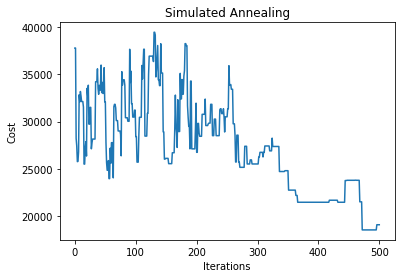

In [60]:
plt.plot(hist_costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Simulated Annealing")

print(f"Final cost:{hist_costs[-1]}")
plt.show()


## Solution 2: Genetic Algorithm

### Solver Class

In [22]:
class GeneticSolver():
    def __init__(self, drivers, riders, graph, evaluation, pop_size, crossover_rate=0.9, mutation_rate=0.1) -> None:
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.drivers = list(drivers)
        self.riders = list(riders)
        self.graph = graph
        self.evaluation_obj = evaluation
        self.debug = False
        self.population = self.initialize_population()
        self.best_score = float("inf")
        

    def initialize_population(self):
        population = list()
        # generate solutions
        for i in range(0, self.pop_size):
            sol = self.generate_solution()
            population.append(sol)
        return population

    def crossover(self):
        max_num_children = self.pop_size//2
        for i in range(0, max_num_children):
            if random.uniform(0, 1) < self.crossover_rate:
                p1, p2 = random.sample(self.population, 2)
                # init child
                num_drivers = len(self.drivers)
                
                child1 = [list() for dr in range(0, num_drivers)]
                # Take permutation from P1 and driver assignment structure from P2
                # permutation of P1 - flatten
                permutation_p1 = [item for sublist in p1 for item in sublist]
                # Assign based on P2
                assignments = 0
                for driver_idx, driver_list in enumerate(p2):
                    child1[driver_idx] = permutation_p1[assignments:assignments + len(driver_list)]
                    assignments += len(driver_list)
                # check
                if self.debug:
                    flat_list = [item for sublist in child1 for item in sublist]
                    assert len(flat_list) == len(self.riders)
                self.population.append(child1)

                child2 = [list() for dr in range(0, num_drivers)]
                # Take permutation from P2 and driver assignment structure from P1
                # permutation of P2 - flatten
                permutation_p2 = [item for sublist in p2 for item in sublist]
                # Assign based on P2
                assignments = 0
                for driver_idx, driver_list in enumerate(p1):
                    child2[driver_idx] = permutation_p2[assignments:assignments + len(driver_list)]
                    assignments += len(driver_list)
                # check
                if self.debug:
                    flat_list = [item for sublist in child2 for item in sublist]
                    assert len(flat_list) == len(self.riders)
                self.population.append(child2)

    # inplace switch two driver assignments
    def mutate_driver_assignment(self):
        for p in self.population:
            if random.uniform(0, 1) < self.mutation_rate:
                selected_drivers = random.sample(range(0, len(self.drivers)), 2)
                driver_a_idx = selected_drivers[0]
                driver_b_idx = selected_drivers[1]
                driver_a = p[driver_a_idx][:]
                driver_b = p[driver_b_idx][:]
                p[driver_a_idx] = driver_b
                p[driver_b_idx] = driver_a

    # inplace switch two riders
    def mutate_rider_sequence(self):
        for p in self.population:
            if random.uniform(0, 1) < self.mutation_rate:
                permutations = [item for sublist in p for item in sublist]
                selected_riders = random.sample(range(0, len(self.riders)), 2)
                rider_1_idx = selected_riders[0]
                rider_2_idx = selected_riders[1]
                rider_id_1 = permutations[rider_1_idx]
                rider_id_2 = permutations[rider_2_idx] 
                mutated_permutations = permutations
                mutated_permutations[rider_1_idx] = rider_id_2
                mutated_permutations[rider_2_idx] = rider_id_1
                assignments = 0
                for driver_idx, driver_list in enumerate(p):
                    p[driver_idx] = mutated_permutations[assignments:assignments + len(driver_list)]
                    assignments += len(driver_list)
    
    def fitness_func(self):
        best_score = float("inf")
        cost_per_solution = []
        for sol in self.population:
            sol_obj = self.index_to_objects(sol)
            self.evaluation_obj.set_solution(sol_obj)
            cost = self.evaluation_obj.evaluate_cost_func()
            cost_per_solution.append(cost)
            if best_score > cost:
                best_score = cost              
        
        # update best score
        if self.best_score > best_score:
            self.best_score = best_score
        # sorted population based on cost per solution
        self.population = [sorted_solution for _, sorted_solution in sorted(zip(cost_per_solution, self.population))]
    
    # update population to be top 50% that minimize objective - Elitism
    def select_parent(self):
        # survival of the fittest
        num_parents = self.pop_size//2
        self.population = self.population[0:num_parents]

    def index_to_objects(self, idx_sol):
        sol_obj = list()
        for driver_assignment in idx_sol:
            driver_assignment_obj = []
            for rider_idx in driver_assignment:
                driver_assignment_obj.append(self.riders[rider_idx])
            sol_obj.append(driver_assignment_obj)
        return sol_obj

    # returns a list of lists of indices representing assignments for each driver
    def generate_solution(self):
        num_riders = len(self.riders)
        num_drivers = len(self.drivers)
        # create list of empty lists
        sol = [list() for dr in range(0, num_drivers)]
        # generate random permutation of riders
        riders_permutation = list(range(num_riders))
        random.shuffle(riders_permutation)
        # Getting N (drivers) random numbers whose sum is M (riders)
        #https://stackoverflow.com/questions/2640053/getting-n-random-numbers-whose-sum-is-m/2640079#2640079
        # Generate N-1 random numbers between 0 and 1
        x = list(np.random.uniform(low = 0.0, high = 1.0, size = num_drivers-1))
        # Add the numbers 0 and 1 themselves to the list and then sort them
        x.extend([0, 1])
        x.sort()
        # Take the differences of adjacent numbers
        diff = [x[i]-x[i-1] for i in range(1, len(x))]
        driver_assigment = [int(item * num_riders) for item in diff]
        sum_assignment = sum(driver_assigment)
        # 
        num_unassigned = num_riders - sum_assignment
        for i in range(0, num_unassigned):
            driver_idx = random.randint(0, num_drivers-1)
            driver_assigment[driver_idx]+=1
        assert sum(driver_assigment) == num_riders
        assert len(driver_assigment) == num_drivers
        for driver_idx, s in enumerate(sol):
            if driver_idx == 0:
                s.extend(riders_permutation[0:driver_assigment[0]])
            else:
                assignments_so_far = sum(driver_assigment[0:driver_idx])
                s.extend(riders_permutation[assignments_so_far:assignments_so_far + driver_assigment[driver_idx]])
        
        if self.debug:
            flat_list = [item for sublist in sol for item in sublist]
            flat_list = list(set(flat_list))
            assert len(flat_list) == num_riders
        return sol

In [23]:
def run_GA(evaluation_object, drivers, riders, graph, initial_pop_size, iterations, crossover_rate=0.9, mutation_rate=0.5, adaptive=False):
    scores = []
    gs_solver = GeneticSolver(drivers, riders, graph, evaluation_object, 
                             pop_size=initial_pop_size, 
                             crossover_rate=crossover_rate, mutation_rate=mutation_rate)
    initial_crossover_rate = gs_solver.crossover_rate
    initial_mutation_rate = gs_solver.mutation_rate
    final_crossover_rate = 0.6
    final_mutation_rate = 0.2
    if adaptive: 
        assert final_crossover_rate <= crossover_rate
        assert final_mutation_rate <= mutation_rate
    for i in tqdm(range(iterations)):
        gs_solver.fitness_func()
        gs_solver.select_parent()
        gs_solver.crossover()
        gs_solver.mutate_rider_sequence()
        gs_solver.mutate_driver_assignment()
        scores.append(gs_solver.best_score)
        if adaptive:
            gs_solver.crossover_rate -= (initial_crossover_rate - final_crossover_rate)/iterations
            gs_solver.mutation_rate -= (initial_mutation_rate - final_mutation_rate)/iterations
    gs_solver = None
    return scores

In [68]:
start = time.time()
hist_costs = run_GA(eval_obj, drivers, riders, graph, initial_pop_size=300, iterations=500, crossover_rate=0.9, mutation_rate=0.4)
end = time.time()
print("")
print("GA time = {} seconds".format(end - start))

100%|██████████| 500/500 [00:36<00:00, 13.54it/s]


GA time = 36.922024726867676 seconds


### Visualize

Final cost:18558.1


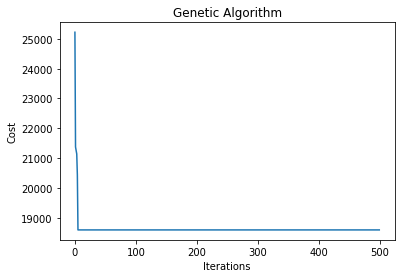

In [70]:
plt.plot(hist_costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Genetic Algorithm")

print(f"Final cost:{hist_costs[-1]}")
plt.show()

## Solution 3: Grey Wolf Algorithm

You can read more about the Grey Wolf Optimizer [here](https://www.sciencedirect.com/science/article/abs/pii/S0965997813001853).

### Wolf Class

In [25]:
class Wolf():
    def __init__(self, solution, eval_obj) -> None:
        self._solution = solution
        self._eval_obj = eval_obj
        self._cost = None
        self.update_cost()

    @property
    def solution(self):
        return self._solution

    @solution.setter
    def solution(self, new_solution):
        self._solution = new_solution

    @property
    def cost(self):
        return self._cost

    @cost.setter
    def cost(self, new_cost):
        self._cost = new_cost

    def update_cost(self):
        self._eval_obj.set_solution(self._solution)
        self.cost = int(self._eval_obj.evaluate_cost_func())

    def __eq__(self, other):
        return self.cost == other.cost

    def __lt__(self, other):
        return self.cost < other.cost

    def __repr__(self) -> str:
        return f'This wolf\'s cost is {self._cost}'

### Solver Class:

In [26]:
class GWSolver():

    def __init__(self, drivers, riders, graph, eval_obj, pack_size, max_hunt_range, iterations) -> None:

        # validations
        if pack_size <= 3:
            raise ValueError('Pack size must be greater than 3')
        if max_hunt_range < 1:
            raise ValueError('Maximum hunting range must be >= 1')

        # problem setup
        self.drivers = drivers
        self.riders = riders
        self.graph = graph
        self.eval_obj = eval_obj
        self.iterations = iterations
        self.iteration = 0
        # grey wolf data
        self.pack = []
        self.leads = []
        # pack_size determines the number of wolves in the pack
        self.pack_size = pack_size
        # max_hunt_range determines how many moves a wolf makes at an iteration
        # begins high and reduces to very few moves at the end
        self.max_hunt_range = max_hunt_range
        self.current_hunt_range = max_hunt_range
        # attack_rate determines how many wolves attack at a given iteration
        # begins low and rises to all wolves attacking at the end
        self.attack_rate = 3  # three leading wolves
        # utilities
        self.ns_generator = NeighborSolutions()

    def generate_wolves_pack(self):
        for i in range(self.pack_size):
            rand_sol = copy.deepcopy(RandomSolution(
                self.drivers, self.riders).get_random_sol())
            a_wolf = Wolf(rand_sol, self.eval_obj)
            self.pack.append(a_wolf)

    def identify_lead_wolves(self):
        self.pack.sort()
        self.leads = self.pack[:3]

    def update_hunting_range(self):
        progress = self.iteration/self.iterations
        num_moves = int((1-(progress))
                        * self.max_hunt_range)
        self.current_hunt_range = num_moves
        self.iteration += 1

    def update_attack_rate(self):
        progress = self.iteration/self.iterations
        # three leading wolves
        self.attack_rate = 3 + int(progress * (self.pack_size - 3))

    def pack_hunts(self):
        for i in range(self.attack_rate, self.pack_size):
            # current wolf's solution
            new_solution = copy.deepcopy(random.choice(self.leads).solution)
            move = 0
            while move <= self.current_hunt_range:
                self.ns_generator.set_solution(new_solution)
                new_solution = copy.deepcopy(random.choice(
                    self.ns_generator.get_neigbors()))
                move += 1
            self.pack[i] = Wolf(new_solution, self.eval_obj)

    def get_status(self):
        avg_cost = 0
        for a_wolf in self.pack:
            avg_cost += a_wolf.cost
        avg_cost = avg_cost / self.pack_size
        return avg_cost

In [63]:
def runGW(drivers, riders, graph, eval_obj, pack_size, max_hunt_range, iterations):
    hist_costs = []
    gw_solver = GWSolver(drivers, riders, graph, eval_obj,
                         pack_size, max_hunt_range, iterations)
    gw_solver.generate_wolves_pack()
    cost_i = gw_solver.get_status()
    hist_costs.append(cost_i)
    for i in tqdm(range(iterations)):
        gw_solver.identify_lead_wolves()
        gw_solver.update_hunting_range()
        gw_solver.update_attack_rate()
        gw_solver.pack_hunts()
        cost_i = gw_solver.get_status()
        hist_costs.append(cost_i)
    return hist_costs

In [64]:
# Grey Wolf parameters
iterations = 500
pack_size = 10
max_hunt_range = 8

# Running GW
start = time.time()
hist_costs = runGW(drivers, riders, graph, eval_obj, pack_size, max_hunt_range, iterations)
end = time.time()
print(f'grey wolf time = {int(end - start)}"')
print(f'grey wolf min cost {min(hist_costs)}')

100%|██████████| 500/500 [00:05<00:00, 92.55it/s] 

grey wolf time = 5"
grey wolf min cost 18272.5


### Visualize

Final cost:18558.1


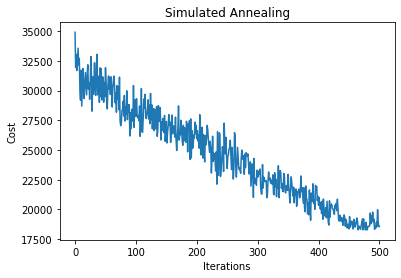

In [65]:
plt.plot(hist_costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Grey Wolf Optimizer")

print(f"Final cost:{hist_costs[-1]}")
plt.show()